# Модификация стехиометрической матрицы $S$ и вычисления $\vec{k}$

Формулу:
$$\frac{d\vec{C}}{dt} = \mathbf{S} \times \vec{W}$$
Преобразовать в формулу:
$$\frac{d\vec{C}}{dt} = \mathbf{A} \times \vec{k}$$

где матрица $\mathbf{A}$ будет изменением матрицы $\mathbf{S}$ с компонентами $\vec{W}$.
Таким образом, нужно выразить матрицу $\mathbf{A}$. По задумке, такой подход к вычислению $\vec{k}$ должен улучшить устойчивость

In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
# import random

from plotly.subplots import make_subplots
from scipy.integrate import solve_ivp
from scipy.interpolate import CubicSpline, UnivariateSpline, LSQUnivariateSpline

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import torch 


import pysindy as ps

# Генерация данных

## Функция для вычисления приращений концентраций веществ

In [26]:
def true_ode_func(t: float, y: np.ndarray, k: np.ndarray) -> np.ndarray:
    """
    Вычисляет производные системы дифференциальных уравнений.
    
    Параметры:
    t : float
        Время (не используется в данном уравнении, но необходим для совместимости с solve_ivp).
    y : np.array
        Вектор переменных (y[0], y[1], ..., y[4]).
    k : np.array
        Константы скоростей реакций (k[0], k[1], ..., k[4]).

    Возвращает:
    dydt : numpy.ndarray
        Вектор производных.
    """
    
    dydt = np.empty_like(y)                          # можно использовать np.zeros_like(y), но это быстрее
    dydt[0] = -2 * k[0] * y[0]**2 - k[1] * y[0]
    dydt[1] = k[0] * y[0]**2 - k[3] * y[1] * y[3]
    dydt[2] = k[1] * y[0] - k[2] * y[2]
    dydt[3] = k[2] * y[2] - k[3] * y[1] * y[3]
    dydt[4] = k[3] * y[1] * y[3]
    return dydt

## Константы

In [27]:
N_REACTION = 4                                                           # кол-во реакций
N_SUBSTANCE = 5                                                          # кол-во веществ
VR_TIME = 40                                                             # время протекания реакций
INIT_CONC = np.array([1.0, 0.5, 0.1, 0.4, 0])                            # начальные концентрации веществ
k = np.array([0.2, 0.1, 0.13, 0.3])                                      # константы скоростей реакций

tspan = [0.0, VR_TIME]                                               # временной промежуток
tsteps = np.linspace(0, VR_TIME, VR_TIME*3 + 1)                # шаги по временному промежутку (количество точек)

# Стехиометрическая матрица (матрица реакций) в базовом виде
MATR = np.array([
    [-2, 1, 0, 0, 0],
    [-1, 0, 1, 0, 0],
    [0, 0, -1, 1, 0],
    [0, -1, 0, -1, 1]
])

MATR_PLUS = np.where(MATR < 0, -MATR, 0)
print(MATR_PLUS)

[[2 0 0 0 0]
 [1 0 0 0 0]
 [0 0 1 0 0]
 [0 1 0 1 0]]


## Вычисление и визуализация изменения концентраций веществ со временем

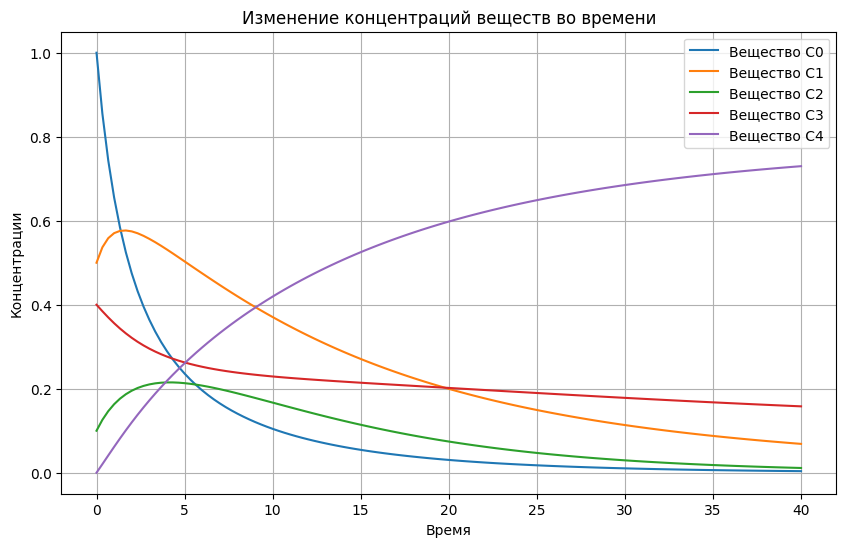

In [28]:
sol = solve_ivp(
        true_ode_func,              # Функция ОДУ
        tspan,                      # Интервал времени
        INIT_CONC,                         # Начальные условия
        args=(k,),                  # Передача параметров в функцию
        method='RK45',              # Метод решения
        t_eval=tsteps               # Точки, в которых сохраняется решение (Шаг)
    )

# Построение графиков
plt.figure(figsize=(10, 6))
for i in range(N_SUBSTANCE):
    plt.plot(sol.t, sol.y[i], label=f'Вещество C{i}')

plt.title('Изменение концентраций веществ во времени')
plt.xlabel('Время')
plt.ylabel('Концентрации')
plt.legend()
plt.grid()
plt.show()

# Сохранение сгенерированных концентраций C в моменты времени. Понадобятся в будущем
CONC_TRUE = sol.y.copy()

## Добавление шума

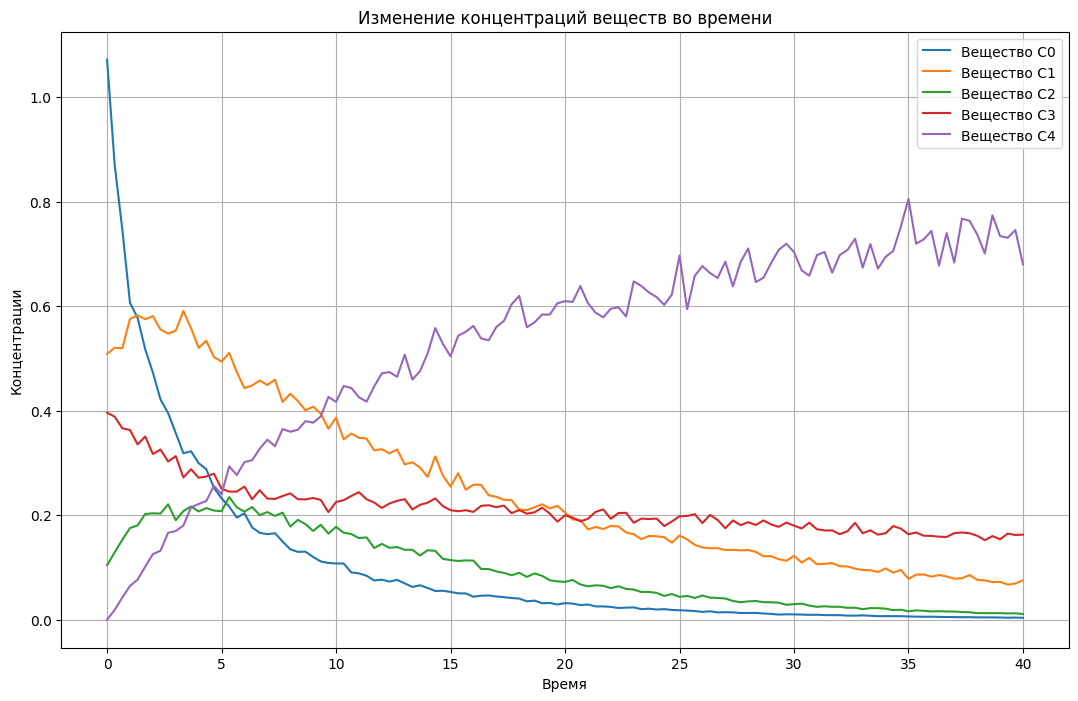

In [29]:
# Генерация шума
noise_level = 4e-2  # Уровень шума

# Создание копии, чтобы работать с ней
y_noisy = sol.y.copy()

# Генерация шума и его добавление
np.random.seed(3)

noise = np.random.normal(0, noise_level * np.abs(y_noisy))          #  это шум
y_noisy += noise                                                    #  это шум

# Построение графиков
plt.figure(figsize=(13, 8))
for i in range(N_SUBSTANCE):
    plt.plot(sol.t, y_noisy[i], label=f'Вещество C{i}')
    # plt.plot(sol.t, sol.y[i])

plt.title('Изменение концентраций веществ во времени')  
plt.xlabel('Время')
plt.ylabel('Концентрации')
plt.legend()
plt.grid(True)
plt.show()


### Сохранение данных в нужном формате

In [30]:
# df = pd.DataFrame(y_noisy.T)
# df.to_csv("generate_concentrations_1.csv", index=False)
# print(df)

# Построение аппроксимации

## Сплайнами

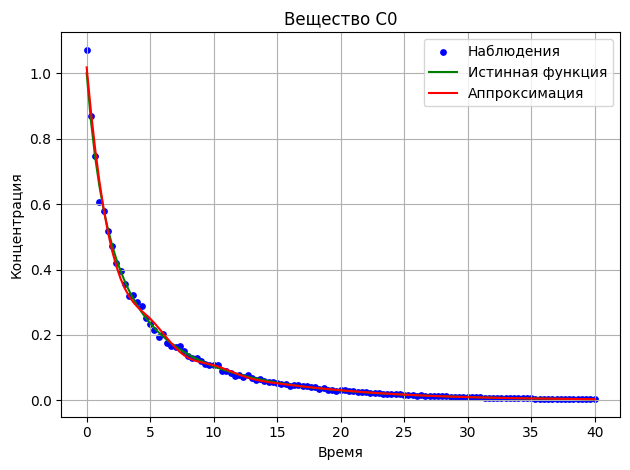

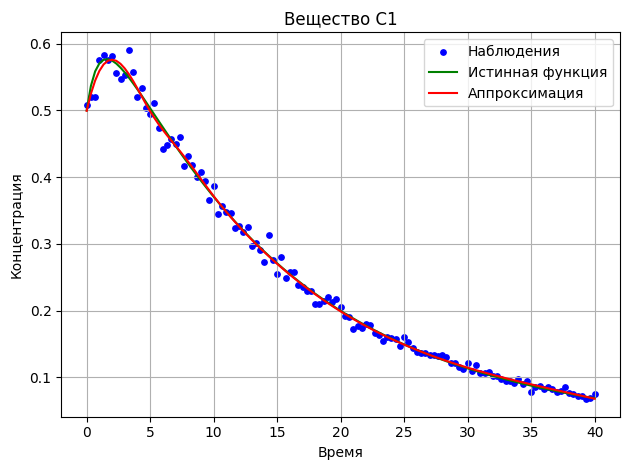

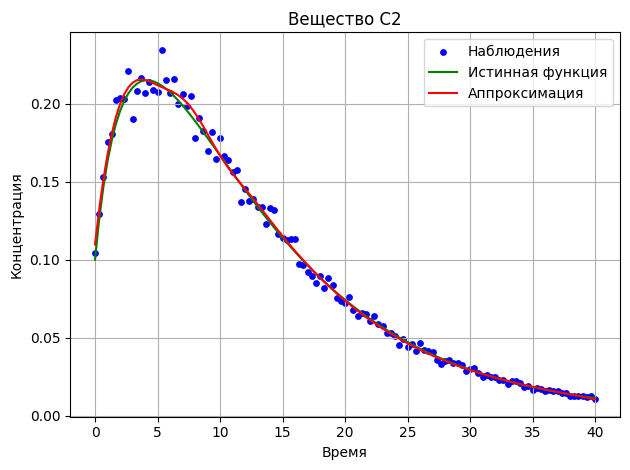

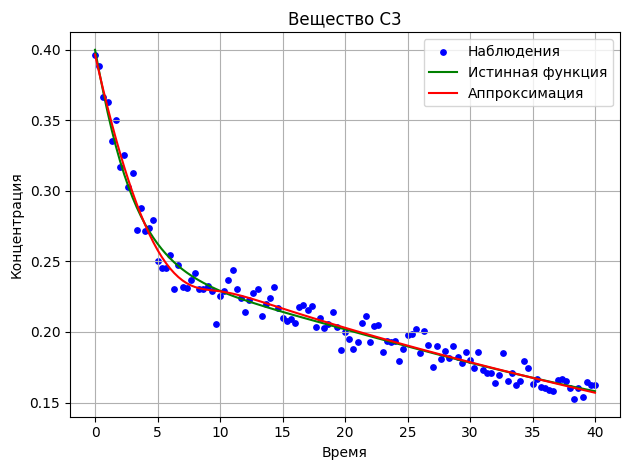

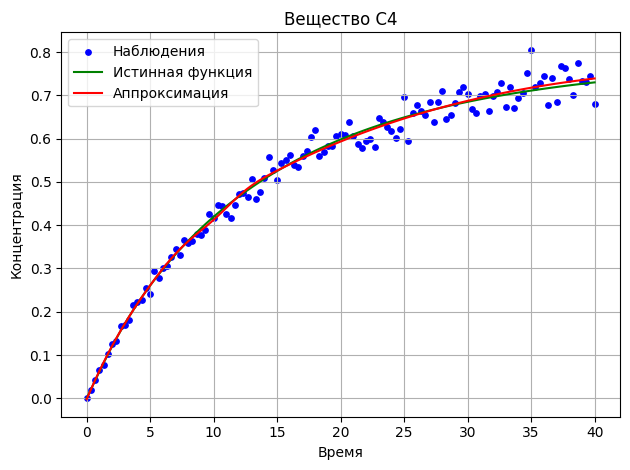

In [31]:
splines = []  # Список для хранения моделей

# Создаем плотную сетку для отображения сплайна
x_dense = np.linspace(0, VR_TIME, len(tsteps) * 1)

# Явное задание узлов разбиения
knots = np.linspace(0, VR_TIME, 7)          
knots = np.delete(knots, [0, -1])           # Узлы должны быть внутри диапазона x, не должны содержать концов

knots_smart = [5., 7.5, 10., 12.5, 15.]                # Сделал меньше промежутки в начале, где происходят интенсивные изменения

# Перебираем вещества
for i in range(N_SUBSTANCE):
    y = y_noisy[i]  # Преобразование в 1D массив

    # Создаем и обучаем модель полиномиальной регрессии
    spline = LSQUnivariateSpline(tsteps, y, knots_smart, k=3)
    splines.append(spline)  # Сохраняем модель

    y_pred = spline(x_dense)
    # y_pred = spline(tsteps)

    # Строим график
    plt.scatter(tsteps, y, color='blue', label='Наблюдения', s=15)
    plt.plot(tsteps, CONC_TRUE[i], color='green', label='Истинная функция')
    plt.plot(x_dense, y_pred, color='red', label='Аппроксимация')
    
    # Настройка графика
    plt.title(f'Вещество C{i}')
    plt.xlabel('Время')
    plt.ylabel('Концентрация')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()
    
    # Вывод коэффициентов
    # r2 = r2_score(CONC_TRUE[i], y_pred)
    # print(f"Вещество C{i}: R^2 = {r2:.6f}")


### Оригинал (прямая задача)

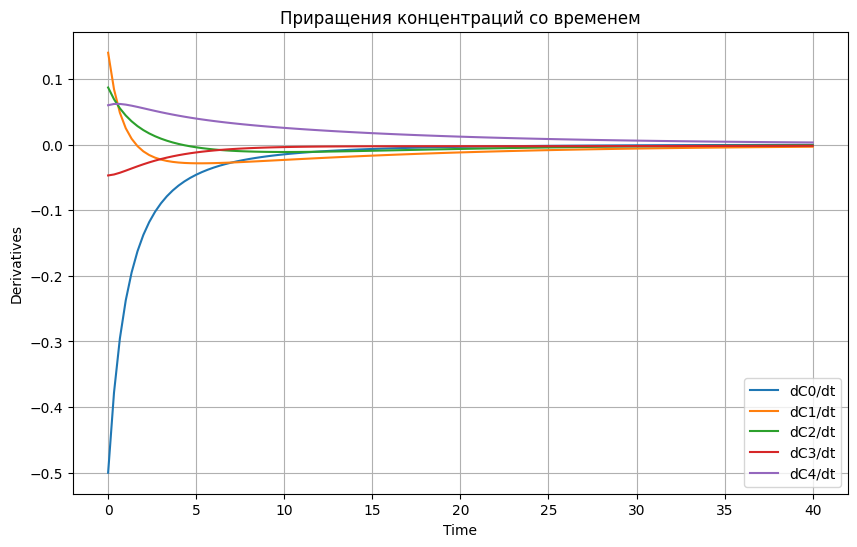

In [32]:
dCdt_TRUE = np.array([true_ode_func(t, y, k) for t, y in zip(sol.t, sol.y.T)]).T      # Приращения по истинным концентрациям C

plt.figure(figsize=(10, 6))
for i in range(dCdt_TRUE.shape[0]):
    plt.plot(sol.t, dCdt_TRUE[i], label=f'dС{i}/dt')

plt.title('Приращения концентраций со временем')
plt.xlabel('Time')
plt.ylabel('Derivatives')
plt.legend()
plt.grid()
plt.show()

### Производная от сплайнов

### Использование ЧМ

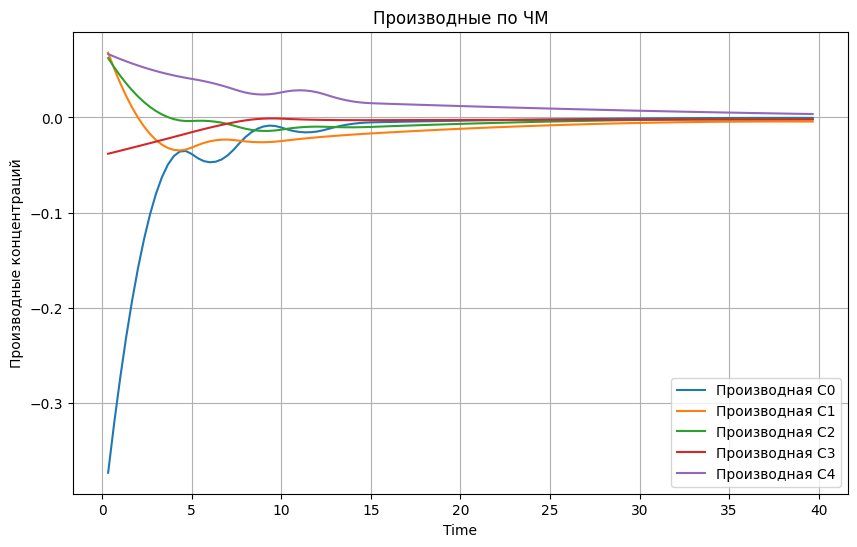

In [33]:
# Построение графиков
plt.figure(figsize=(10, 6))

h = tsteps[1] - tsteps[0]
dCdt_NM = np.zeros_like(dCdt_TRUE)

for i, spl in enumerate(splines):
    dCdt_NM[i][1:-1] = (spl(tsteps[2:]) - spl(tsteps[:-2])) / (2 * h)    # центральная разность
    dCdt_NM[i][0] = (spl(tsteps[1]) - spl(tsteps[0])) / h                # левая разность
    dCdt_NM[i][-1] = (spl(tsteps[-1]) - spl(tsteps[-2])) / h             # правая разность

    # Вывод на график
    plt.plot(tsteps[1:-1], dCdt_NM[i][1:-1], label=f'Производная C{i}')

plt.xlabel('Time')
plt.ylabel('Производные концентраций')
plt.title('Производные по ЧМ')
plt.legend()
plt.grid()
plt.show()

### Аппроксимация ЧМ сплайнами

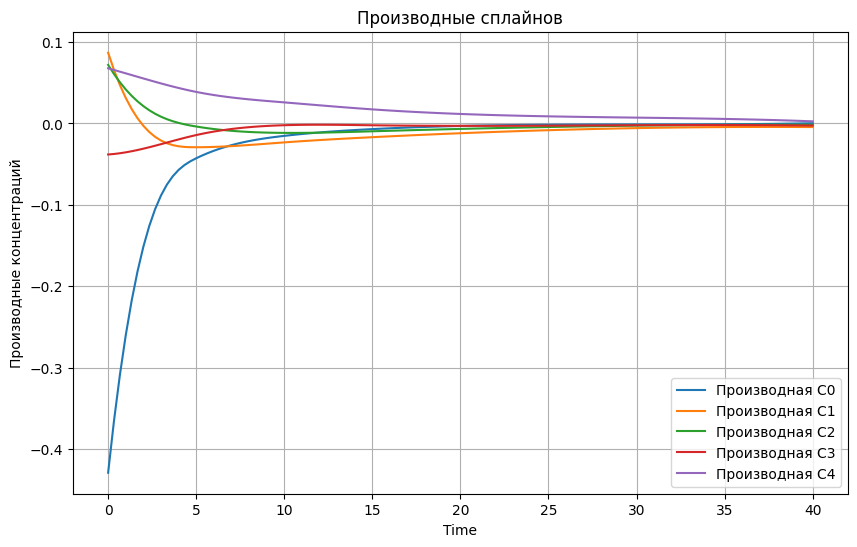

In [34]:
splines_NM = []
knots = [5, 10, 15]

for i in range(N_SUBSTANCE):
    y = dCdt_NM[i]  # Преобразование в 1D массив

    # Создаем и обучаем модель полиномиальной регрессии
    spline = LSQUnivariateSpline(tsteps, y, knots, k=3)
    splines_NM.append(spline)  # Сохраняем модель

    y_pred = spline(tsteps)

dCdt_spline_NM = np.zeros_like(dCdt_TRUE)         # Приращения в обратной задаче

# Построение графиков
plt.figure(figsize=(10, 6))

for i, spl in enumerate(splines_NM):
    dCdt_spline_NM[i, :] = spl(tsteps)

    # Вывод на график
    plt.plot(tsteps, dCdt_spline_NM[i], label=f'Производная C{i}')

plt.xlabel('Time')
plt.ylabel('Производные концентраций')
plt.title('Производные сплайнов')
plt.legend()
plt.grid()
plt.show()

## Графики остатков производных

### От сплайнов по ЧМ

In [35]:
fig = go.Figure()

# Добавляем линии для каждого вещества
for i in range(N_SUBSTANCE):
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=dCdt_TRUE[i] - dCdt_spline_NM[i], 
        mode='lines', 
        name=f'Приращение C{i}'
    ))

# Настройки графика
fig.update_layout(
    title='Производные концентраций веществ',
    xaxis_title='Time',
    yaxis_title='Производные концентраций',
    legend_title='Приращения',
    template='plotly_white',
    width=1400,  # Ширина холста
    height=800   # Высота холста
)

fig.show()

# Вычисление k

In [36]:
K_TRUE = np.zeros((N_REACTION, len(tsteps)))                        # k по изначальным данным
k_spline_NM = np.zeros((N_REACTION, len(tsteps)))                      # k по сплайнам
k_mod_steh_matr = np.zeros((N_REACTION, len(tsteps)))                      # k по модифицированной стехиометрической матрице

W_TRUE = np.zeros((N_REACTION, len(tsteps)))                        # W(скорости реакций) по изначальным данным
W_spline_NM = np.zeros((N_REACTION, len(tsteps)))                      # W по сплайнам


C_TRUE = np.zeros((N_SUBSTANCE, len(tsteps)))                       # C(концентрации) по изначальным данным
C_spline_NM = np.zeros((N_SUBSTANCE, len(tsteps)))                     # C по сплайнам


In [37]:
matrix_transformations = np.linalg.inv(MATR @ MATR.T) @ MATR
print(matrix_transformations)

[[-0.3125  0.375  -0.3125 -0.3125  0.0625]
 [-0.3125 -0.625   0.6875  0.6875  0.0625]
 [-0.25   -0.5    -0.25    0.75    0.25  ]
 [-0.1875 -0.375  -0.1875 -0.1875  0.4375]]


### k по начальным данным

In [38]:
# t = np.linspace(0, 30, 31)         # Базово использовать tsteps

for i, val in enumerate(tsteps):
    W = matrix_transformations @ dCdt_TRUE.T[i]
    C = CONC_TRUE[:, i]
    result = np.prod(C ** MATR_PLUS, axis=1)

    W_TRUE[:, i] = W
    C_TRUE[:, i] = C
    K_TRUE[:, i] = W / result  # Заполняем i-й столбец матрицы k_eval

# print(k_eval)


### k по сплайнам с ЧМ производными

In [39]:
# t = np.linspace(0, 30, 31)         # Базово использовать tsteps

for i, val in enumerate(tsteps):
    W = matrix_transformations @ dCdt_spline_NM.T[i]
    C = [float(splines[0](tsteps[i])), float(splines[1](tsteps[i])), float(splines[2](tsteps[i])), float(splines[3](tsteps[i])), float(splines[4](tsteps[i]))]
    result = np.prod(C ** MATR_PLUS, axis=1)

    W_spline_NM[:, i] = W
    C_spline_NM[:, i] = C
    k_spline_NM[:, i] = W / result  # Заполняем i-й столбец матрицы k_pred

# print(k_pred)

## Преобразование стехиометрической матрицы

Формулу:
$$\frac{d\vec{C}}{dt} = \mathbf{S} \times \vec{W}$$
Преобразовать в формулу:
$$\frac{d\vec{C}}{dt} = \mathbf{A} \times \vec{k}$$

$$\vec{k} = (\mathbf{A}^T \mathbf{A})^{-1} \mathbf{A}^T \times \frac{d\vec{C}}{dt}$$

In [40]:
for i, val in enumerate(tsteps):
    C = [float(splines[0](tsteps[i])), float(splines[1](tsteps[i])), float(splines[2](tsteps[i])), float(splines[3](tsteps[i])), float(splines[4](tsteps[i]))]
    P = np.prod(C ** MATR_PLUS, axis=1)
    A = MATR.T * P

    k_mod_steh_matr[:, i] = np.linalg.inv(A.T @ A) @ A.T @ dCdt_spline_NM.T[i]
    C_spline_NM[:, i] = C

## Генерация k в ходе обратной задачи 

In [41]:
# Задаем цвета (4 цвета для реакций)
colors = ['blue', 'red', 'green', 'purple']

# Создаем два подграфика (2 столбца, 1 строка)
fig = make_subplots(rows=1, cols=2, subplot_titles=['Orig', 'Spline'])

# Первый график (прямая задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=K_TRUE[i, :], 
        mode='lines', 
        name=f'Реакция {i} (прямая)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=1)

# Второй график (обратная задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=k_spline_NM[i, :], 
        mode='lines', 
        name=f'Реакция {i} (обратная)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=2)

# Настройки общего макета
fig.update_layout(
    template='plotly_white',
    width=1400,  # Общая ширина холста
    height=700,  # Высота холста
    showlegend=True
)

# Ограничение оси Y
fig.update_yaxes(range=[-2, 4], title_text='Коэффициент k', row=1, col=1)
fig.update_yaxes(range=[-2, 4], title_text='Коэффициент k', row=1, col=2)

# Подписи оси X
fig.update_xaxes(title_text='Время, t', row=1, col=1)
fig.update_xaxes(title_text='Время, t', row=1, col=2)

# Отображение графика
fig.show()


In [42]:
# Задаем цвета (4 цвета для реакций)
colors = ['blue', 'red', 'green', 'purple']

# Создаем два подграфика (2 столбца, 1 строка)
fig = make_subplots(rows=1, cols=2, subplot_titles=['Spline', 'Matrix_S_in_A'])

# Первый график (прямая задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=k_spline_NM[i, :], 
        mode='lines', 
        name=f'Реакция {i} (прямая)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=1)

# Второй график (обратная задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=k_mod_steh_matr[i, :], 
        mode='lines', 
        name=f'Реакция {i} (обратная)',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=2)

# Настройки общего макета
fig.update_layout(
    template='plotly_white',
    width=1400,  # Общая ширина холста
    height=700,  # Высота холста
    showlegend=True
)

# Ограничение оси Y
fig.update_yaxes(range=[-2, 4], title_text='Коэффициент k', row=1, col=1)
fig.update_yaxes(range=[-2, 4], title_text='Коэффициент k', row=1, col=2)

# Подписи оси X
fig.update_xaxes(title_text='Время, t', row=1, col=1)
fig.update_xaxes(title_text='Время, t', row=1, col=2)

# Отображение графика
fig.show()


In [43]:
mean_spline_NM = np.round(np.mean(k_spline_NM[:, :60], axis=1), 3)
print('Средние k по Spline_NM:     ', *mean_spline_NM)
median_spline_NM = np.round(np.median(k_spline_NM[:, :60], axis=1), 3)
print('Медианные k по Spline_NM:   ', *median_spline_NM)

print()
mean_Matrix_S_in_A = np.round(np.mean(k_mod_steh_matr[:, :60], axis=1), 3)
print('Средние k по Matrix_S_in_A:     ', *mean_Matrix_S_in_A)
median_Matrix_S_in_A = np.round(np.median(k_mod_steh_matr[:, :60], axis=1), 3)
print('Медианные k по Matrix_S_in_A:   ', *median_Matrix_S_in_A)

print()
print('k = ', k)

Средние k по Spline_NM:      0.202 0.102 0.135 0.302
Медианные k по Spline_NM:    0.201 0.104 0.13 0.299

Средние k по Matrix_S_in_A:      0.202 0.102 0.135 0.302
Медианные k по Matrix_S_in_A:    0.201 0.104 0.13 0.299

k =  [0.2  0.1  0.13 0.3 ]


# W - скорости реакций

In [44]:
colors = ['blue', 'red', 'green', 'purple']

# Создаем два подграфика (2 столбца, 1 строка)
fig = make_subplots(rows=1, cols=2, subplot_titles=['W-orig', 'W-spline'])

# Первый график (прямая задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=W_TRUE[i, :], 
        mode='lines', 
        name=f'Реакция {i}',
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=1)

# Второй график (обратная задача)
for i in range(N_REACTION):  
    fig.add_trace(go.Scatter(
        x=tsteps, 
        y=W_spline_NM[i, :], 
        mode='lines', 
        line=dict(color=colors[i % len(colors)])  # Применяем цвета циклично
    ), row=1, col=2)

# Настройки общего макета
fig.update_layout(
    template='plotly_white',
    width=1400,  # Общая ширина холста
    height=700,  # Высота холста
    showlegend=True
)

# Ограничение оси Y
fig.update_yaxes(range=[-0.05, 0.2], title_text='Коэффициент k', row=1, col=1)
fig.update_yaxes(range=[-0.05, 0.2], title_text='Коэффициент k', row=1, col=2)

# Подписи оси X
fig.update_xaxes(title_text='Время, t', row=1, col=1)
fig.update_xaxes(title_text='Время, t', row=1, col=2)

# Отображение графика
fig.show()
